In [110]:
import torch
torch.set_num_threads(1)
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

In [2]:
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

#Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [3]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

## Model 

In [4]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
def mlpf_loss(y, ypred):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    npart = y["pt"].numel()

    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = 100 * loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = 10 * torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all particles
    loss["Classification"] = loss_classification.sum() / npart
    loss["Regression"] = loss_regression.sum() / npart

    loss["Total"] = loss["Classification"] + loss["Regression"]
    return loss
    
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ELU
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act()
        )
        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        x = self.mul.mul(x, mask.unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ELU
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum

model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

## Training

In [5]:
max_events_train = 1000
events_per_batch = 10

#Training loop
inds_train = range(0,max_events_train,events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0]!=0

    preds = model(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    loss["Total"].backward()
    optimizer.step()
    print("Loss={:.2f}".format(loss["Total"].detach().item()))

Loss=116.82
Loss=106.76
Loss=101.56
Loss=97.74
Loss=95.95
Loss=95.71
Loss=96.90
Loss=92.94
Loss=87.17
Loss=84.19
Loss=86.13
Loss=82.17
Loss=79.44
Loss=86.49
Loss=73.99
Loss=73.83
Loss=71.08
Loss=62.84
Loss=71.09
Loss=73.03
Loss=56.18
Loss=65.16
Loss=57.76
Loss=64.74
Loss=65.40
Loss=62.81
Loss=57.39
Loss=58.74
Loss=55.07
Loss=63.72
Loss=54.26
Loss=46.95
Loss=54.10
Loss=50.18
Loss=52.51
Loss=48.49
Loss=45.61
Loss=54.27
Loss=49.53
Loss=43.92
Loss=54.04
Loss=49.27
Loss=44.29
Loss=39.57
Loss=47.40
Loss=45.53
Loss=49.88
Loss=50.85
Loss=47.61
Loss=44.79
Loss=47.13
Loss=42.42
Loss=33.34
Loss=40.21
Loss=44.26
Loss=39.74
Loss=32.85
Loss=36.08
Loss=42.22
Loss=36.89
Loss=45.28
Loss=39.39
Loss=40.25
Loss=41.15
Loss=39.63
Loss=38.17
Loss=44.32
Loss=38.19
Loss=50.86
Loss=36.78
Loss=41.61
Loss=38.38
Loss=43.52
Loss=38.36
Loss=39.95
Loss=40.99
Loss=37.85
Loss=33.99
Loss=34.56
Loss=32.56
Loss=33.65
Loss=33.05
Loss=33.40
Loss=36.13
Loss=34.49
Loss=35.19
Loss=34.41
Loss=32.84
Loss=34.70
Loss=36.89
Loss=36

## Evaluation

In [6]:
preds = model(X_features_padded, mask)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked = unpack_predictions(preds)
targets_unpacked = unpack_target(y_targets_padded)

In [7]:
msk_true_particles = targets_unpacked["cls_id"]!=0

pt_target = targets_unpacked["pt"][msk_true_particles].numpy()
pt_pred = preds_unpacked["pt"][msk_true_particles].numpy()

eta_target = targets_unpacked["eta"][msk_true_particles].numpy()
eta_pred = preds_unpacked["eta"][msk_true_particles].numpy()

sphi_target = targets_unpacked["sin_phi"][msk_true_particles].numpy()
sphi_pred = preds_unpacked["sin_phi"][msk_true_particles].numpy()

cphi_target = targets_unpacked["cos_phi"][msk_true_particles].numpy()
cphi_pred = preds_unpacked["cos_phi"][msk_true_particles].numpy()

energy_target = targets_unpacked["energy"][msk_true_particles].numpy()
energy_pred = preds_unpacked["energy"][msk_true_particles].numpy()

Text(0, 0.5, 'pred pt')

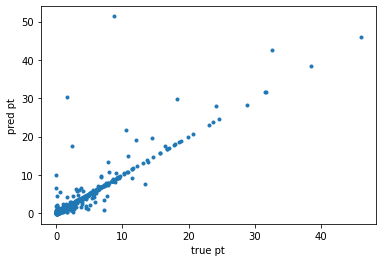

In [8]:
plt.scatter(
    pt_target,
    pt_pred,
    marker="."
)
plt.xlabel("true pt")
plt.ylabel("pred pt")

Text(0, 0.5, 'pred eta')

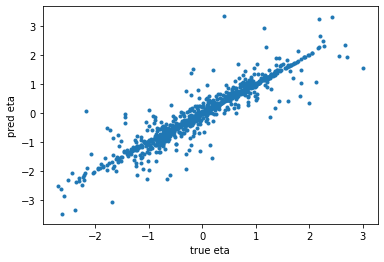

In [9]:
plt.scatter(
    eta_target,
    eta_pred,
    marker="."
)
plt.xlabel("true eta")
plt.ylabel("pred eta")

Text(0, 0.5, 'pred sin phi')

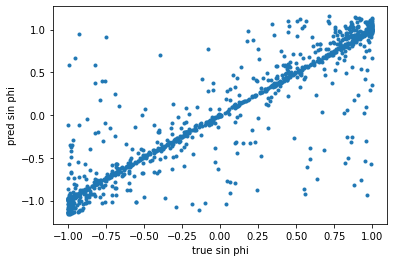

In [10]:
plt.scatter(
    sphi_target,
    sphi_pred,
    marker="."
)
plt.xlabel("true sin phi")
plt.ylabel("pred sin phi")

Text(0, 0.5, 'pred cos phi')

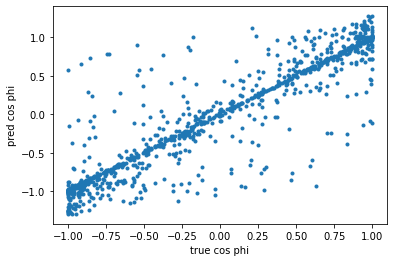

In [11]:
plt.scatter(
    cphi_target,
    cphi_pred,
    marker="."
)
plt.xlabel("true cos phi")
plt.ylabel("pred cos phi")

Text(0, 0.5, 'pred energy')

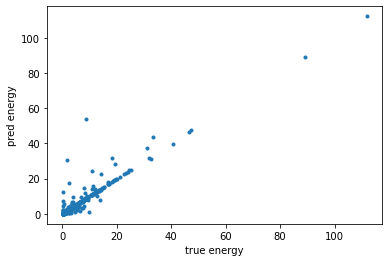

In [12]:
plt.scatter(
    energy_target,
    energy_pred,
    marker="."
)
plt.xlabel("true energy")
plt.ylabel("pred energy")

## Quantization
We are doing quantizatio with the Eager mode

In [149]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_prepared = torch.ao.quantization.prepare(model)

#calibrate on data
num_events_to_calibrate = 1
for ind in range(1000,1000+num_events_to_calibrate):
    X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    mask = X[:, :, 0]!=0
    model_prepared(X, mask)

model_int8 = torch.ao.quantization.convert(model_prepared)

In [140]:
from scipy.stats import pearsonr


In [141]:
model.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=False){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

---

In [164]:
# Get the default qconfig
qconfig = torch.ao.quantization.get_default_qconfig('x86')

# Define a new QConfig with per-tensor symmetric quantization for weights
new_weight_observer = torch.ao.quantization.default_observer.with_args(qscheme=torch.per_tensor_symmetric)
new_activation_observer = torch.ao.quantization.default_observer.with_args(qscheme=torch.per_tensor_symmetric)

new_qconfig = torch.ao.quantization.QConfig(activation=new_activation_observer, weight=new_weight_observer)

# Apply the modified qconfig to the model
model.qconfig = new_qconfig

# Prepare the model for quantization
model_prepared = torch.quantization.prepare(model, inplace=True)

In [174]:
print(new_weight_observer)


functools.partial(functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, dtype=torch.qint8){}


---

In [179]:
# Get the default qconfig
qconfig = torch.ao.quantization.get_default_qconfig('x86')

# Define a new QConfig with per-channel affine quantization for activation
new_activation_observer = functools.partial(
    torch.ao.quantization.default_observer.with_args,
    dtype=torch.float32
)
new_weight_observer = functools.partial(
    torch.ao.quantization.default_observer.with_args,
    dtype=torch.qint8,
    quant_min=0,
    quant_max=127
)

new_qconfig = torch.ao.quantization.QConfig(
    activation=new_activation_observer,
    weight=new_weight_observer
)

# Apply the modified qconfig to the model
model.qconfig = new_qconfig

# Prepare the model for quantization
model_prepared = torch.quantization.prepare(model.eval())

# Calibrate on data
num_events_to_calibrate = 1
for ind in range(1000, 1000 + num_events_to_calibrate):
    X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    mask = X[:, :, 0] != 0
    model_prepared(X, mask)

# Convert the model to int8
model_int8 = torch.quantization.convert(model_prepared)

AssertionError: Weight observer must have dtype torch.qint8

----

In [142]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
preds = model_int8(X_features_padded, mask_quantized)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked_int8 = unpack_predictions(preds)

In [143]:
pt_pred_int8 = preds_unpacked_int8["pt"][msk_true_particles].numpy()
eta_pred_int8 = preds_unpacked_int8["eta"][msk_true_particles].numpy()
sphi_pred_int8 = preds_unpacked_int8["sin_phi"][msk_true_particles].numpy()
cphi_pred_int8 = preds_unpacked_int8["cos_phi"][msk_true_particles].numpy()
energy_pred_int8 = preds_unpacked_int8["energy"][msk_true_particles].numpy()

Correlation Coefficient: 0.9996425887323582
p-value: 0.0


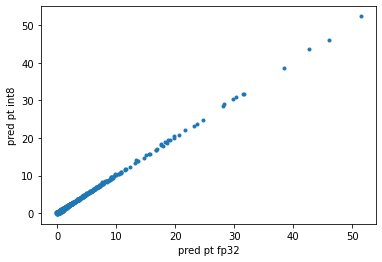

In [144]:
plt.scatter(
    pt_pred,
    pt_pred_int8,
    marker="."
)
plt.xlabel("pred pt fp32")
plt.ylabel("pred pt int8")


correlation_coefficient = np.corrcoef(pt_pred, pt_pred_int8)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

corr_coefficient, p_value = pearsonr(pt_pred, pt_pred_int8)
print("p-value:", p_value)

Correlation Coefficient: 0.9907409524856351


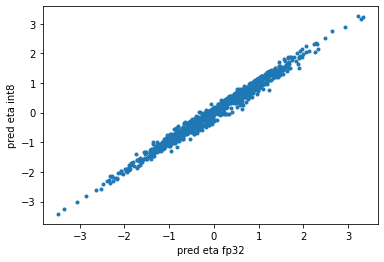

In [145]:
plt.scatter(
    eta_pred,
    eta_pred_int8,
    marker="."
)
plt.xlabel("pred eta fp32")
plt.ylabel("pred eta int8")

correlation_coefficient = np.corrcoef(eta_pred, eta_pred_int8)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.9903977357398237


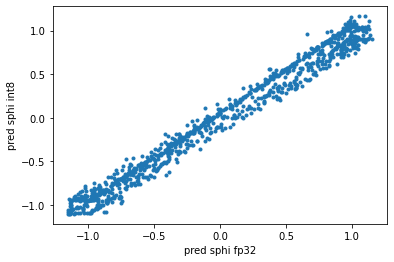

In [146]:
plt.scatter(
    sphi_pred,
    sphi_pred_int8,
    marker="."
)
plt.xlabel("pred sphi fp32")
plt.ylabel("pred sphi int8")

correlation_coefficient = np.corrcoef(sphi_pred, sphi_pred_int8)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.9860811472427253


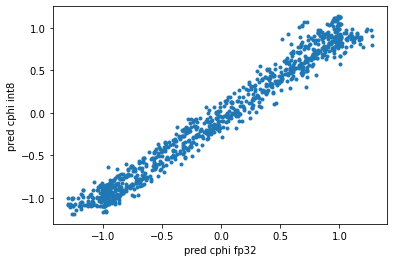

In [147]:
plt.scatter(
    cphi_pred,
    cphi_pred_int8,
    marker="."
)
plt.xlabel("pred cphi fp32")
plt.ylabel("pred cphi int8")


correlation_coefficient = np.corrcoef(cphi_pred, cphi_pred_int8)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)



Correlation Coefficient: 0.9998841107505937


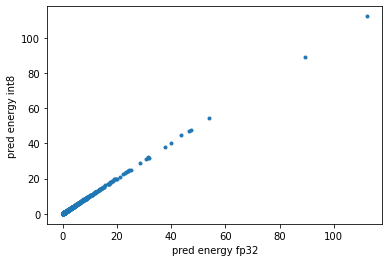

In [148]:
plt.scatter(
    energy_pred,
    energy_pred_int8,
    marker="."
)
plt.xlabel("pred energy fp32")
plt.ylabel("pred energy int8")



correlation_coefficient = np.corrcoef(energy_pred, energy_pred_int8)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)


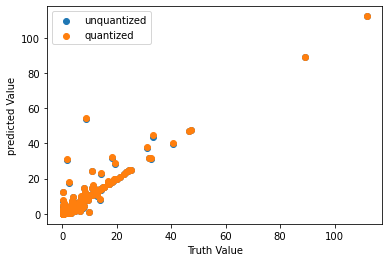

In [67]:
plt.scatter(energy_target, energy_pred, label="unquantized")
plt.scatter(energy_target, energy_pred_int8, label="quantized")
plt.ylabel("predicted Value")
plt.xlabel("Truth Value")
plt.legend()

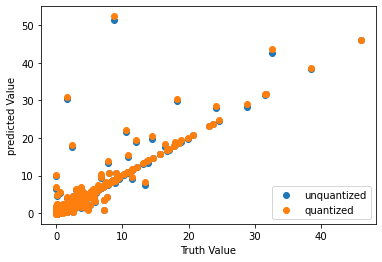

In [68]:
plt.scatter(pt_target, pt_pred, label="unquantized")
plt.scatter(pt_target, pt_pred_int8, label="quantized")
plt.ylabel("predicted Value")
plt.xlabel("Truth Value")
plt.legend()

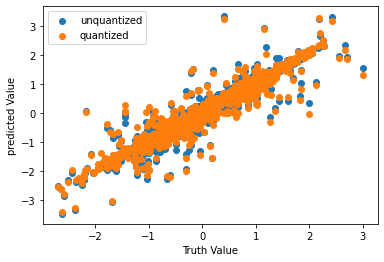

In [69]:
plt.scatter(eta_target, eta_pred, label="unquantized")
plt.scatter(eta_target, eta_pred_int8, label="quantized")
plt.ylabel("predicted Value")
plt.xlabel("Truth Value")
plt.legend()

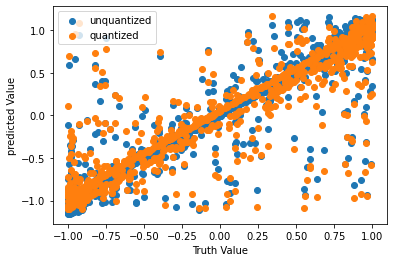

In [70]:
plt.scatter(sphi_target, sphi_pred, label="unquantized")
plt.scatter(sphi_target, sphi_pred_int8, label="quantized")
plt.ylabel("predicted Value")
plt.xlabel("Truth Value")
plt.legend()

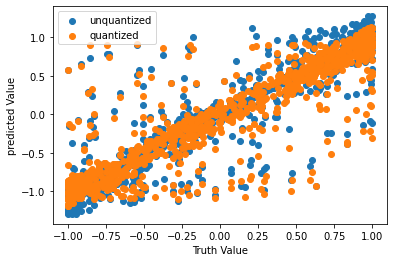

In [71]:
plt.scatter(cphi_target, cphi_pred, label="unquantized")
plt.scatter(cphi_target, cphi_pred_int8, label="quantized")
plt.ylabel("predicted Value")
plt.xlabel("Truth Value")
plt.legend()

In [72]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0078]), zero_point=tensor([0]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0243]), zero_point=tensor([93]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0157]), zero_point=tensor([140]), dtype=torch.quint8)
    (3-4): 2 x Quantize(scale=tensor([0.0078]), zero_point=tensor([128]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0254]), zero_point=tensor([78]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([15.2592]), zero_point=tensor([149]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([14.6373]), zero_point=tensor([130]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([22.1658]), zero_point=tensor([126]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0114]), zero_point=tensor([0]), dtype=torch.quint8)
    (10): Quantize(scale=tensor([1.3424]), zero_point=tensor([0]), dtype=torch.quint8)
    (11): Quantize(scale=tensor([0.0706]), zero_point=tensor([63]), dtyp

In [28]:
import time

In [29]:
for i in range(3):
    t0 = time.time()
    for j in range(100):
        model(X_features_padded, X_features_padded[:, :, 0]!=0)
    t1 = time.time()
    print(t1 - t0)

37.932711124420166
38.509063482284546
38.34154558181763


In [ ]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
for i in range(3):
    t0 = time.time()
    for j in range(100):
        model_int8(X_features_padded, mask_quantized)
    t1 = time.time()
    print(t1 - t0)

In [ ]:
X_features_padded.shape

In [ ]:
export_options = torch.onnx.ExportOptions(dynamic_shapes=True)
onnx_program = torch.onnx.dynamo_export(model, X_features_padded, X_features_padded[:, :, 0]!=0, export_options=export_options)
onnx_program.save("mlpf_fp32.onnx")

In [ ]:
# This doesn't work
# export_options = torch.onnx.ExportOptions(dynamic_shapes=True)
# onnx_program = torch.onnx.dynamo_export(model_int8, X_features_padded, mask_quantized, export_options=export_options)
# onnx_program.save("mlpf_int8.onnx")